# EfficientNetB2 - Waste Classification
## TensorFlow Implementation (Windows/CUDA)

**Model:** EfficientNetB2 (ImageNet pretrained)

**Objective:** Compare performance between preprocessed and raw datasets

**Hardware:** Windows RTX 3060 Ti (CUDA)

**Classes:** aluminium, paper, plastic

---
## 1. Import Libraries and Setup

In [ ]:
!pip install numpy pandas matplotlib seaborn scikit-learn tensorflow[and-cuda]==2.20.0

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# 1. Hide oneDNN messages
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

# 2. Hide standard TensorFlow INFO messages (including the CPU instruction ones)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB2
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support

# Import custom logger
sys.path.append('..')
from result_logger import log_result

# Check GPU availability and CUDA compatibility
print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))
print("CUDA Available:", tf.test.is_built_with_cuda())

# Additional CUDA check
if tf.config.list_physical_devices('GPU'):
    print("✅ GPU is available and TensorFlow can use it!")
    # Test GPU computation
    with tf.device('/GPU:0'):
        a = tf.constant([[1.0, 2.0], [3.0, 4.0]])
        b = tf.constant([[1.0, 0.0], [0.0, 1.0]])
        c = tf.matmul(a, b)
        print("GPU test successful:", c.numpy())
else:
    print("❌ GPU not available. Check CUDA installation.")
    print("💡 Windows Troubleshooting:")
    print("   1. Install CUDA 12.0+ toolkit from NVIDIA website")
    print("   2. Install cuDNN 8.9+ compatible with CUDA 12.x")
    print("   3. Add CUDA bin path to Windows PATH")
    print("   4. Restart VS Code/Jupyter after installation")
    print("   5. Try: pip install nvidia-cuda-runtime-cu12 nvidia-cudnn-cu12")

TensorFlow version: 2.20.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
CUDA Available: True
✅ GPU is available and TensorFlow can use it!
GPU test successful: [[1. 2.]
 [3. 4.]]


I0000 00:00:1769979388.840835    1458 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5592 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Ti, pci bus id: 0000:01:00.0, compute capability: 8.6


---
## 2. Dataset Paths Configuration
Define all dataset paths as constants

In [2]:
# Dataset Configuration
CLASSES = ['aluminium', 'paper', 'plastic']
NUM_CLASSES = 3
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Set A: Preprocessed Public (Training Data)
PREPROCESSED_TRAIN = r"../Dataset/preprocessed_Public/train"
PREPROCESSED_VAL = r"../Dataset/preprocessed_Public/val"
PREPROCESSED_TEST_PUBLIC = r"../Dataset/preprocessed_Public/test"

# Set B: Preprocessed Self-Collected (Final Testing)
PREPROCESSED_TEST_SELF = r"../Dataset/preprocessed_self/test"

# Set C: Raw Data (For Comparison)
RAW_PUBLIC = r"../Dataset/Public_dataset"
RAW_SELF = r"../Dataset/SelfCollected_Dataset"

# Create results directory
os.makedirs('results', exist_ok=True)
os.makedirs('models', exist_ok=True)

print("✓ Paths configured successfully")

✓ Paths configured successfully


---
## 3. Data Generators Setup
Create data loaders with proper preprocessing

In [3]:
def create_data_generators(train_path, val_path, test_path, use_augmentation=True):
    """
    Create data generators for training, validation, and testing
    
    Args:
        train_path: Path to training data
        val_path: Path to validation data (if None, use train_path with validation_split)
        test_path: Path to test data
        use_augmentation: Whether to apply data augmentation
    
    Returns:
        train_gen, val_gen, test_gen
    """
    
    if use_augmentation:
        # Training data generator with augmentation
        train_datagen = ImageDataGenerator(
            preprocessing_function=preprocess_input,
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2,
            horizontal_flip=True,
            zoom_range=0.2,
            fill_mode='nearest'
        )
    else:
        train_datagen = ImageDataGenerator(
            preprocessing_function=preprocess_input
        )
    
    # Validation and test generators (no augmentation)
    val_test_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input
    )
    
    # Create generators
    train_gen = train_datagen.flow_from_directory(
        train_path,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=True,
        classes=CLASSES
    )
    
    if val_path and os.path.exists(val_path):
        val_gen = val_test_datagen.flow_from_directory(
            val_path,
            target_size=IMG_SIZE,
            batch_size=BATCH_SIZE,
            class_mode='categorical',
            shuffle=False,
            classes=CLASSES
        )
    else:
        # Use validation split from training data
        val_gen = None
    
    test_gen = val_test_datagen.flow_from_directory(
        test_path,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False,
        classes=CLASSES
    )
    
    return train_gen, val_gen, test_gen

print("✓ Data generator function defined")

✓ Data generator function defined


---
## 4. Model Architecture
Build EfficientNetB2 with custom classification head

In [4]:
def build_efficientnetb2_model():
    """
    Build EfficientNetB2 model with custom classification head
    
    Returns:
        Compiled Keras model
    """
    
    # Load pretrained EfficientNetB2 (without top classification layer)
    base_model = EfficientNetB2(
        weights='imagenet',
        include_top=False,
        input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)
    )
    
    # Freeze base model layers initially
    base_model.trainable = False
    
    # Build custom classification head
    inputs = keras.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)
    
    model = keras.Model(inputs, outputs)
    
    # Compile model
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

print("✓ Model architecture function defined")

✓ Model architecture function defined


---
## 5. Training Function
Complete training pipeline with callbacks

In [5]:
def train_model(model, train_gen, val_gen, model_name, epochs=30, fine_tune=True):
    """
    Train the model with optional fine-tuning
    
    Args:
        model: Keras model
        train_gen: Training data generator
        val_gen: Validation data generator
        model_name: Name for saving the model
        epochs: Number of training epochs
        fine_tune: Whether to fine-tune base model layers
    
    Returns:
        Training history
    """
    
    # Callbacks
    callbacks = [
        EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=1e-7,
            verbose=1
        ),
        ModelCheckpoint(
            f'models/{model_name}.keras',
            monitor='val_accuracy',
            save_best_only=True,
            verbose=1
        )
    ]
    
    print(f"\n{'='*60}")
    print(f"Training Phase 1: Training Classification Head")
    print(f"{'='*60}\n")
    
    # Phase 1: Train with frozen base
    history_phase1 = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=epochs // 2,
        callbacks=callbacks,
        verbose=1
    )
    
    if fine_tune:
        print(f"\n{'='*60}")
        print(f"Training Phase 2: Fine-Tuning Base Model")
        print(f"{'='*60}\n")
        
        # Unfreeze base model for fine-tuning
        model.layers[1].trainable = True  # base_model
        
        # Recompile with lower learning rate
        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=1e-5),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
        
        # Phase 2: Fine-tune
        history_phase2 = model.fit(
            train_gen,
            validation_data=val_gen,
            epochs=epochs // 2,
            callbacks=callbacks,
            verbose=1
        )
        
        # Combine histories
        history = history_phase1
        for key in history_phase1.history.keys():
            history.history[key].extend(history_phase2.history[key])
    else:
        history = history_phase1
    
    return history

print("✓ Training function defined")

✓ Training function defined


---
## 6. Evaluation Function
Evaluate model and generate metrics

In [6]:
def evaluate_model(model, test_gen, experiment_name):
    """
    Evaluate model and display results
    
    Args:
        model: Trained Keras model
        test_gen: Test data generator
        experiment_name: Name of the experiment
    
    Returns:
        Dictionary with evaluation metrics
    """
    
    print(f"\n{'='*60}")
    print(f"Evaluating: {experiment_name}")
    print(f"{'='*60}\n")
    
    # Get predictions
    test_gen.reset()
    y_pred_probs = model.predict(test_gen, verbose=1)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = test_gen.classes
    
    # Calculate metrics
    test_loss, test_acc = model.evaluate(test_gen, verbose=0)
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average='weighted'
    )
    
    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=CLASSES))
    
    # Display confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=CLASSES, yticklabels=CLASSES)
    plt.title(f'Confusion Matrix - {experiment_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print(f"\n{'='*60}")
    print(f"Results Summary - {experiment_name}")
    print(f"{'='*60}")
    print(f"Test Loss:      {test_loss:.4f}")
    print(f"Test Accuracy:  {test_acc:.4f}")
    print(f"Precision:      {precision:.4f}")
    print(f"Recall:         {recall:.4f}")
    print(f"F1-Score:       {f1:.4f}")
    print(f"{'='*60}\n")
    
    return {
        'loss': test_loss,
        'accuracy': test_acc,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

print("✓ Evaluation function defined")

✓ Evaluation function defined


---
## 7. Experiment 1: Preprocessed Dataset
Train on preprocessed public data, test on preprocessed self-collected data

In [ ]:
print("\n" + "#"*60)
print("# EXPERIMENT 1: PREPROCESSED DATASET")
print("#"*60 + "\n")

# Create data generators
train_gen_prep, val_gen_prep, test_gen_prep = create_data_generators(
    PREPROCESSED_TRAIN,
    PREPROCESSED_VAL,
    PREPROCESSED_TEST_SELF,
    use_augmentation=True
)

# Build model
model_prep = build_efficientnetb2_model()
print("\nModel Summary:")
model_prep.summary()

# Train model
history_prep = train_model(
    model_prep,
    train_gen_prep,
    val_gen_prep,
    model_name='efficientnetb2_preprocessed',
    epochs=30,
    fine_tune=True
)

# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy
axes[0].plot(history_prep.history['accuracy'], label='Train Accuracy')
axes[0].plot(history_prep.history['val_accuracy'], label='Val Accuracy')
axes[0].set_title('Model Accuracy - Preprocessed')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True)

# Loss
axes[1].plot(history_prep.history['loss'], label='Train Loss')
axes[1].plot(history_prep.history['val_loss'], label='Val Loss')
axes[1].set_title('Model Loss - Preprocessed')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

# Evaluate on test set
results_prep = evaluate_model(model_prep, test_gen_prep, "EfficientNetB2 - Preprocessed")

# Log results
log_result(
    model_name='EfficientNetB2',
    experiment_type='Preprocessed',
    accuracy=results_prep['accuracy'],
    precision=results_prep['precision'],
    recall=results_prep['recall'],
    f1=results_prep['f1'],
    loss=results_prep['loss']
)

print("✓ Experiment 1 completed and results logged")

---
## 8. Experiment 2: Raw Dataset
Train on raw public data, test on raw self-collected data


############################################################
# EXPERIMENT 2: RAW DATASET
############################################################

Found 2684 images belonging to 3 classes.
Found 533 images belonging to 3 classes.
Found 2148 images belonging to 3 classes.
Found 536 images belonging to 3 classes.

Training Phase 1: Training Classification Head

Epoch 1/15


2026-02-02 04:56:56.238466: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-02 04:56:56.457259: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-02 04:56:57.454022: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-02 04:56:57.701151: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-02 04:56:58.585195: E external/local_xla/xla/stream_

62/68 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.7893 - loss: 0.5885

2026-02-02 04:57:24.860340: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-02 04:57:25.084306: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-02 04:57:25.854945: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-02 04:57:26.107544: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-02 04:57:26.790949: E external/local_xla/xla/stream_

68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step - accuracy: 0.7969 - loss: 0.5705

2026-02-02 04:57:52.555218: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-02 04:57:52.773000: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-02 04:57:52.984114: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-02 04:57:53.854896: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-02 04:57:54.080985: E external/local_xla/xla/stream_


Epoch 1: val_accuracy improved from None to 0.93843, saving model to models/efficientnetb2_raw.keras

Epoch 1: finished saving model to models/efficientnetb2_raw.keras
68/68 ━━━━━━━━━━━━━━━━━━━━ 89s 790ms/step - accuracy: 0.8771 - loss: 0.3800 - val_accuracy: 0.9384 - val_loss: 0.1967 - learning_rate: 0.0010
Epoch 2/15
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.9587 - loss: 0.1212
Epoch 2: val_accuracy did not improve from 0.93843
68/68 ━━━━━━━━━━━━━━━━━━━━ 9s 125ms/step - accuracy: 0.9544 - loss: 0.1326 - val_accuracy: 0.9291 - val_loss: 0.1848 - learning_rate: 0.0010
Epoch 3/15
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.9521 - loss: 0.1296
Epoch 3: val_accuracy did not improve from 0.93843
68/68 ━━━━━━━━━━━━━━━━━━━━ 10s 141ms/step - accuracy: 0.9567 - loss: 0.1093 - val_accuracy: 0.9366 - val_loss: 0.1555 - learning_rate: 0.0010
Epoch 4/15
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.9713 - loss: 0.0748
Epoch 4: val_accuracy improved from 0.93843 to 

2026-02-02 05:00:47.076502: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-02 05:00:47.297445: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-02 05:00:47.524318: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-02 05:00:56.693558: E external/local_xla/xla/service/slow_operation_alarm.cc:73] Trying algorithm eng18{k11=2} for conv (f32[528,1,5,5]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,528,14,14]{3,2,1,0}, f32[32,528,14,14]{3,2,1,0}), window={size=5x5 pad=2_2x2_2}, dim_labels=bf01_oi01->bf01, fea

 2/68 ━━━━━━━━━━━━━━━━━━━━ 7s 112ms/step - accuracy: 0.7734 - loss: 0.6146   

2026-02-02 05:01:39.625228: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-02 05:01:39.877837: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 782ms/step - accuracy: 0.7822 - loss: 0.6831
Epoch 1: val_accuracy did not improve from 0.95149
68/68 ━━━━━━━━━━━━━━━━━━━━ 153s 1s/step - accuracy: 0.7952 - loss: 0.6388 - val_accuracy: 0.9291 - val_loss: 0.1873 - learning_rate: 1.0000e-05
Epoch 2/15
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.8387 - loss: 0.4751
Epoch 2: val_accuracy did not improve from 0.95149
68/68 ━━━━━━━━━━━━━━━━━━━━ 11s 152ms/step - accuracy: 0.8385 - loss: 0.4849 - val_accuracy: 0.9216 - val_loss: 0.2366 - learning_rate: 1.0000e-05
Epoch 3/15
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.8540 - loss: 0.3883
Epoch 3: val_accuracy did not improve from 0.95149
68/68 ━━━━━━━━━━━━━━━━━━━━ 9s 133ms/step - accuracy: 0.8645 - loss: 0.3865 - val_accuracy: 0.9160 - val_loss: 0.2599 - learning_rate: 1.0000e-05
Epoch 4/15
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.8719 - loss: 0.3434
Epoch 4: val_accuracy did not improve from 0.95149
68/68 ━━━━━━━━━━━━━━━━━━━━ 1

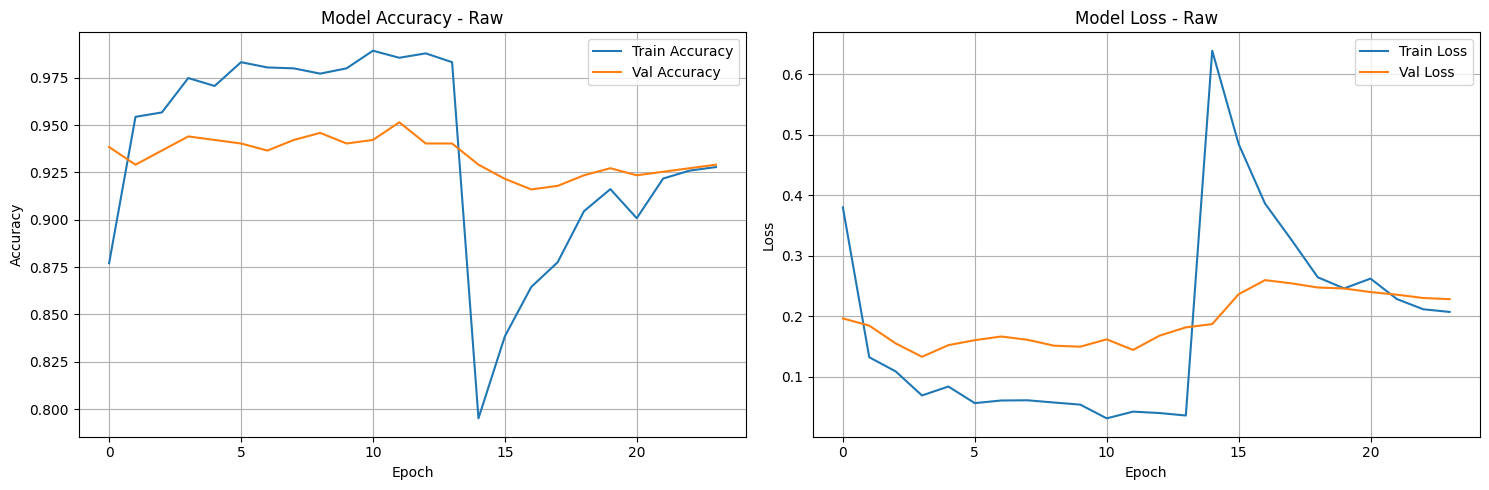


Evaluating: EfficientNetB2 - Raw

16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step

2026-02-02 05:04:21.790703: E external/local_xla/xla/service/slow_operation_alarm.cc:73] Trying algorithm eng3{k11=2} for conv (f32[21,528,14,14]{3,2,1,0}, u8[0]{0}) custom-call(f32[21,528,14,14]{3,2,1,0}, f32[528,1,3,3]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, feature_group_count=528, custom_call_target="__cudnn$convForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false,"reification_cost":[]} is taking a while...
2026-02-02 05:04:22.679557: E external/local_xla/xla/service/slow_operation_alarm.cc:140] The operation took 1.889075126s
Trying algorithm eng3{k11=2} for conv (f32[21,528,14,14]{3,2,1,0}, u8[0]{0}) custom-call(f32[21,528,14,14]{3,2,1,0}, f32[528,1,3,3]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, feature_group_count=528, custom_call_target="__cudnn

17/17 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step 

Classification Report:
              precision    recall  f1-score   support

   aluminium       0.66      0.75      0.70       148
       paper       0.73      0.65      0.69       151
     plastic       0.75      0.74      0.75       234

    accuracy                           0.72       533
   macro avg       0.71      0.71      0.71       533
weighted avg       0.72      0.72      0.72       533



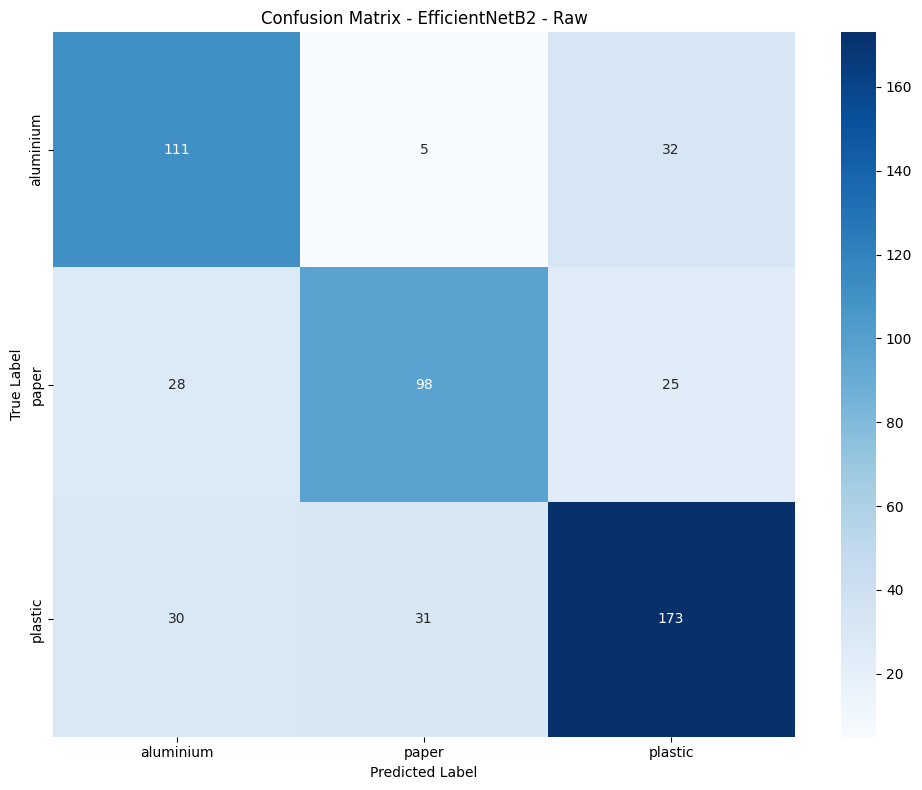


Results Summary - EfficientNetB2 - Raw
Test Loss:      0.8575
Test Accuracy:  0.7167
Precision:      0.7198
Recall:         0.7167
F1-Score:       0.7167

✓ Results logged: EfficientNetB2 - Raw
  Accuracy: 0.7167, Precision: 0.7198, Recall: 0.7167, F1: 0.7167
✓ Experiment 2 completed and results logged


In [7]:
print("\n" + "#"*60)
print("# EXPERIMENT 2: RAW DATASET")
print("#"*60 + "\n")

# Create data generators for raw data
train_gen_raw, _, test_gen_raw = create_data_generators(
    RAW_PUBLIC,
    None,  # No separate validation, will use validation_split
    RAW_SELF,
    use_augmentation=True
)

# Create validation generator from training data
val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2
)

train_gen_raw = val_datagen.flow_from_directory(
    RAW_PUBLIC,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    classes=CLASSES,
    subset='training'
)

val_gen_raw = val_datagen.flow_from_directory(
    RAW_PUBLIC,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
    classes=CLASSES,
    subset='validation'
)

# Build new model
model_raw = build_efficientnetb2_model()

# Train model
history_raw = train_model(
    model_raw,
    train_gen_raw,
    val_gen_raw,
    model_name='efficientnetb2_raw',
    epochs=30,
    fine_tune=True
)

# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy
axes[0].plot(history_raw.history['accuracy'], label='Train Accuracy')
axes[0].plot(history_raw.history['val_accuracy'], label='Val Accuracy')
axes[0].set_title('Model Accuracy - Raw')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True)

# Loss
axes[1].plot(history_raw.history['loss'], label='Train Loss')
axes[1].plot(history_raw.history['val_loss'], label='Val Loss')
axes[1].set_title('Model Loss - Raw')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

# Evaluate on test set
results_raw = evaluate_model(model_raw, test_gen_raw, "EfficientNetB2 - Raw")

# Log results
log_result(
    model_name='EfficientNetB2',
    experiment_type='Raw',
    accuracy=results_raw['accuracy'],
    precision=results_raw['precision'],
    recall=results_raw['recall'],
    f1=results_raw['f1'],
    loss=results_raw['loss']
)

print("✓ Experiment 2 completed and results logged")

---
## 9. Load Saved Models and Evaluate
If models are already trained and saved, load them and get evaluation results

Loading model from models/efficientnetb2_preprocessed.keras
✓ Model loaded successfully
Loading model from models/efficientnetb2_raw.keras
✓ Model loaded successfully
Found 7512 images belonging to 3 classes.
Found 403 images belonging to 3 classes.
Found 533 images belonging to 3 classes.

Evaluating: EfficientNetB2 - Preprocessed (Loaded)

17/17 ━━━━━━━━━━━━━━━━━━━━ 17s 555ms/step

Classification Report:
              precision    recall  f1-score   support

   aluminium       0.60      0.63      0.61       148
       paper       0.59      0.70      0.64       151
     plastic       0.72      0.62      0.67       234

    accuracy                           0.64       533
   macro avg       0.64      0.65      0.64       533
weighted avg       0.65      0.64      0.64       533



Loading model from models/efficientnetb2_preprocessed.keras
✓ Model loaded successfully
Loading model from models/efficientnetb2_raw.keras
✓ Model loaded successfully
Found 7512 images belonging to 3 classes.
Found 403 images belonging to 3 classes.
Found 533 images belonging to 3 classes.

Evaluating: EfficientNetB2 - Preprocessed (Loaded)

17/17 ━━━━━━━━━━━━━━━━━━━━ 17s 555ms/step

Classification Report:
              precision    recall  f1-score   support

   aluminium       0.60      0.63      0.61       148
       paper       0.59      0.70      0.64       151
     plastic       0.72      0.62      0.67       234

    accuracy                           0.64       533
   macro avg       0.64      0.65      0.64       533
weighted avg       0.65      0.64      0.64       533



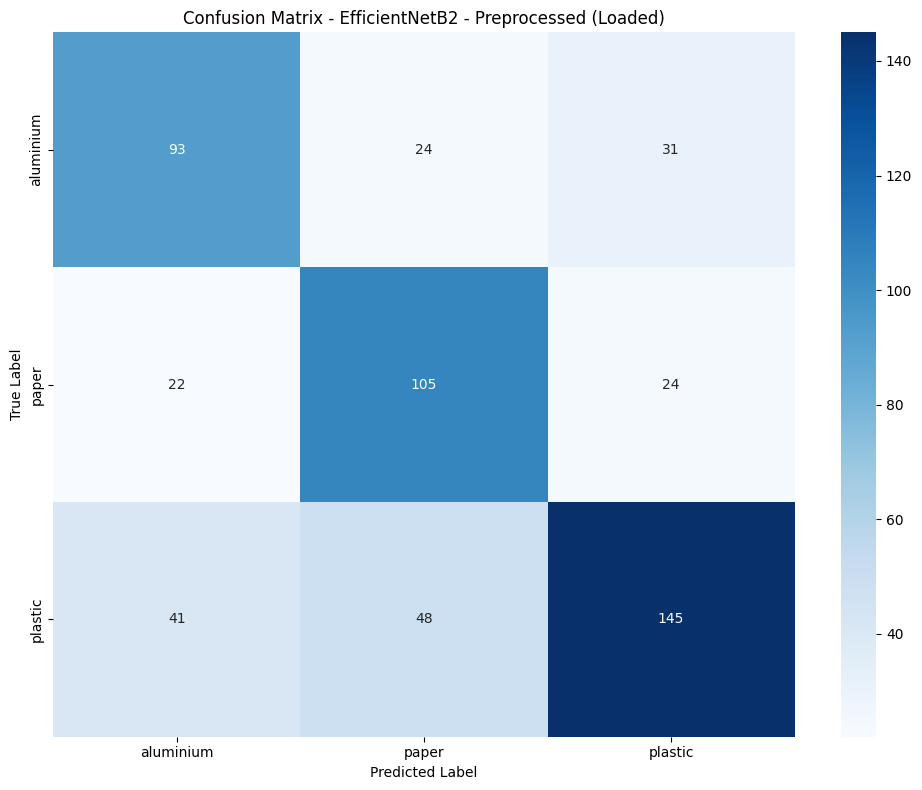

Loading model from models/efficientnetb2_preprocessed.keras
✓ Model loaded successfully
Loading model from models/efficientnetb2_raw.keras
✓ Model loaded successfully
Found 7512 images belonging to 3 classes.
Found 403 images belonging to 3 classes.
Found 533 images belonging to 3 classes.

Evaluating: EfficientNetB2 - Preprocessed (Loaded)

17/17 ━━━━━━━━━━━━━━━━━━━━ 17s 555ms/step

Classification Report:
              precision    recall  f1-score   support

   aluminium       0.60      0.63      0.61       148
       paper       0.59      0.70      0.64       151
     plastic       0.72      0.62      0.67       234

    accuracy                           0.64       533
   macro avg       0.64      0.65      0.64       533
weighted avg       0.65      0.64      0.64       533



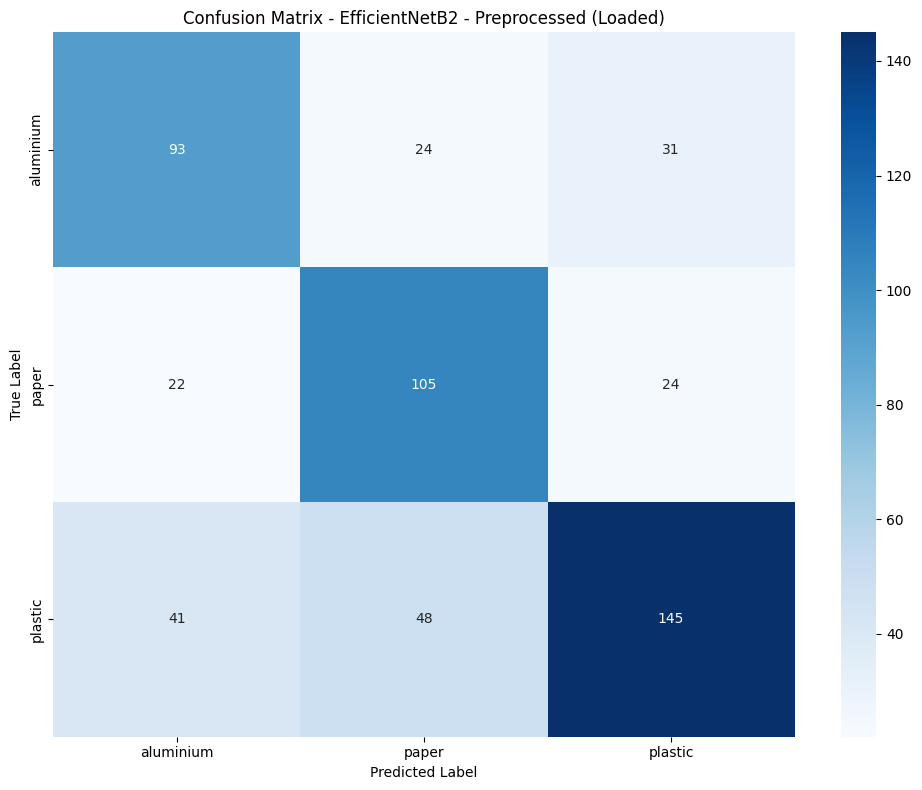


Results Summary - EfficientNetB2 - Preprocessed (Loaded)
Test Loss:      1.1880
Test Accuracy:  0.6435
Precision:      0.6519
Recall:         0.6435
F1-Score:       0.6446

Found 2148 images belonging to 3 classes.
Found 536 images belonging to 3 classes.
Found 533 images belonging to 3 classes.

Evaluating: EfficientNetB2 - Raw (Loaded)

17/17 ━━━━━━━━━━━━━━━━━━━━ 17s 610ms/step

Classification Report:
              precision    recall  f1-score   support

   aluminium       0.69      0.76      0.72       148
       paper       0.75      0.71      0.73       151
     plastic       0.79      0.76      0.78       234

    accuracy                           0.75       533
   macro avg       0.74      0.75      0.74       533
weighted avg       0.75      0.75      0.75       533



Loading model from models/efficientnetb2_preprocessed.keras
✓ Model loaded successfully
Loading model from models/efficientnetb2_raw.keras
✓ Model loaded successfully
Found 7512 images belonging to 3 classes.
Found 403 images belonging to 3 classes.
Found 533 images belonging to 3 classes.

Evaluating: EfficientNetB2 - Preprocessed (Loaded)

17/17 ━━━━━━━━━━━━━━━━━━━━ 17s 555ms/step

Classification Report:
              precision    recall  f1-score   support

   aluminium       0.60      0.63      0.61       148
       paper       0.59      0.70      0.64       151
     plastic       0.72      0.62      0.67       234

    accuracy                           0.64       533
   macro avg       0.64      0.65      0.64       533
weighted avg       0.65      0.64      0.64       533



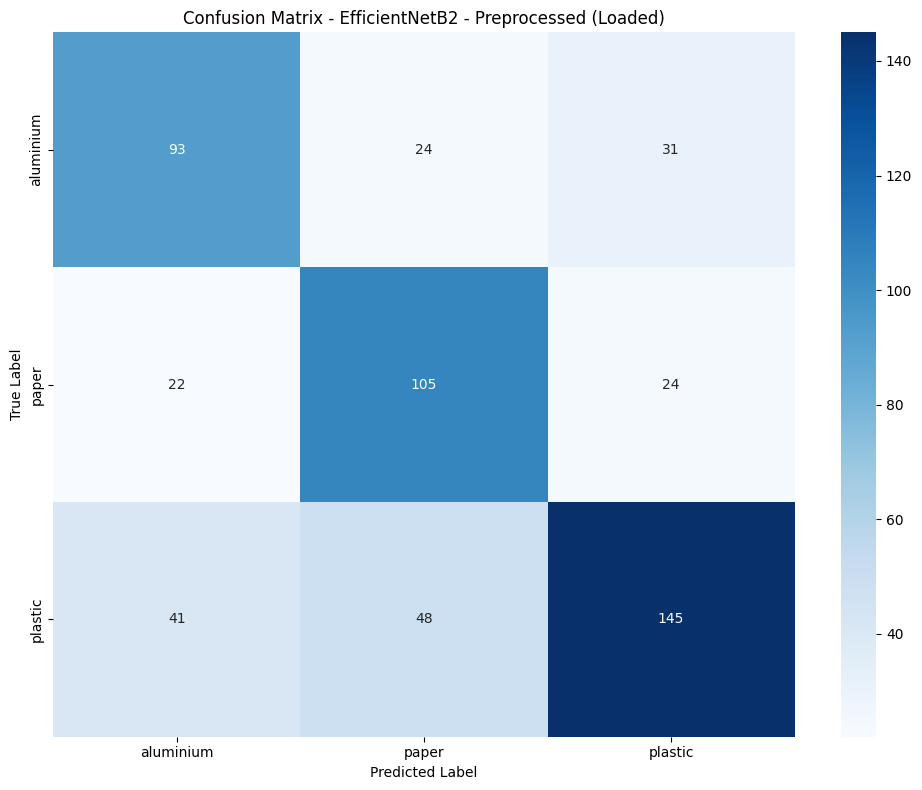


Results Summary - EfficientNetB2 - Preprocessed (Loaded)
Test Loss:      1.1880
Test Accuracy:  0.6435
Precision:      0.6519
Recall:         0.6435
F1-Score:       0.6446

Found 2148 images belonging to 3 classes.
Found 536 images belonging to 3 classes.
Found 533 images belonging to 3 classes.

Evaluating: EfficientNetB2 - Raw (Loaded)

17/17 ━━━━━━━━━━━━━━━━━━━━ 17s 610ms/step

Classification Report:
              precision    recall  f1-score   support

   aluminium       0.69      0.76      0.72       148
       paper       0.75      0.71      0.73       151
     plastic       0.79      0.76      0.78       234

    accuracy                           0.75       533
   macro avg       0.74      0.75      0.74       533
weighted avg       0.75      0.75      0.75       533



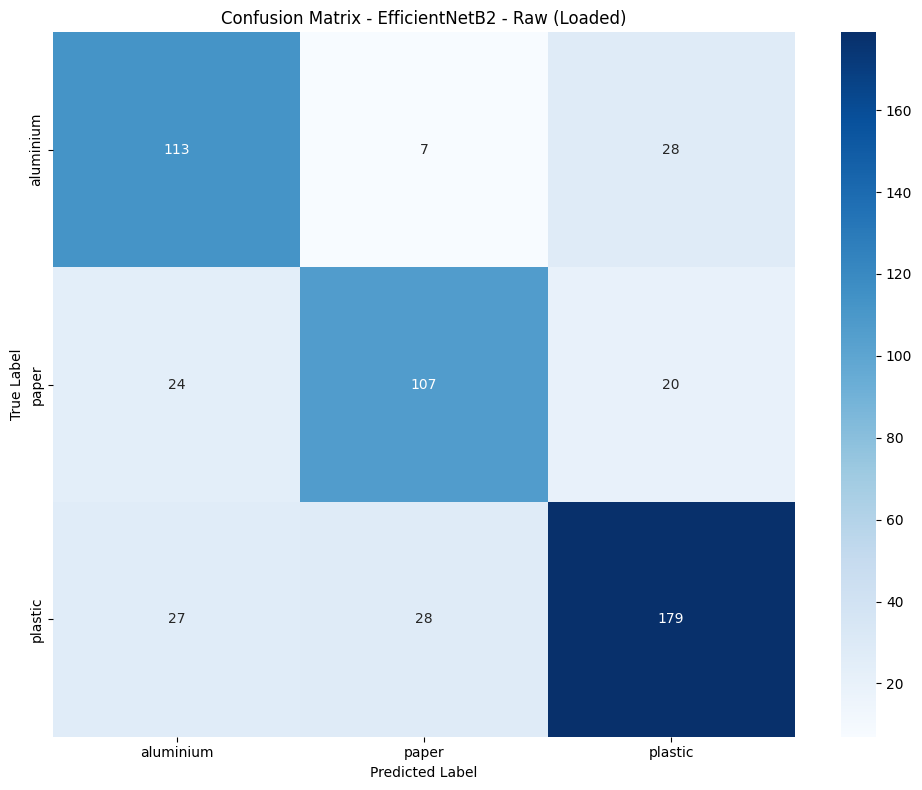


Results Summary - EfficientNetB2 - Raw (Loaded)
Test Loss:      0.9607
Test Accuracy:  0.7486
Precision:      0.7510
Recall:         0.7486
F1-Score:       0.7490

✓ Saved models loaded and evaluated


In [9]:
# Load saved models if they exist
def load_saved_model(model_path):
    """
    Load a saved Keras model
    
    Args:
        model_path: Path to the saved model file
    
    Returns:
        Loaded Keras model
    """
    if os.path.exists(model_path):
        print(f"Loading model from {model_path}")
        model = keras.models.load_model(model_path)
        print("✓ Model loaded successfully")
        return model
    else:
        print(f"❌ Model not found at {model_path}")
        return None

# Load preprocessed model
model_prep_path = 'models/efficientnetb2_preprocessed.keras'
model_prep = load_saved_model(model_prep_path)

# Load raw model
model_raw_path = 'models/efficientnetb2_raw.keras'
model_raw = load_saved_model(model_raw_path)

# If models are loaded, evaluate them
if model_prep is not None:
    # Create data generators for preprocessed
    train_gen_prep, val_gen_prep, test_gen_prep = create_data_generators(
        PREPROCESSED_TRAIN,
        PREPROCESSED_VAL,
        PREPROCESSED_TEST_SELF,
        use_augmentation=False  # No need for augmentation during evaluation
    )
    results_prep = evaluate_model(model_prep, test_gen_prep, "EfficientNetB2 - Preprocessed (Loaded)")

if model_raw is not None:
    # Create data generators for raw
    val_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input,
        validation_split=0.2
    )
    train_gen_raw = val_datagen.flow_from_directory(
        RAW_PUBLIC,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=True,
        classes=CLASSES,
        subset='training'
    )
    val_gen_raw = val_datagen.flow_from_directory(
        RAW_PUBLIC,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False,
        classes=CLASSES,
        subset='validation'
    )
    test_gen_raw = ImageDataGenerator(preprocessing_function=preprocess_input).flow_from_directory(
        RAW_SELF,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False,
        classes=CLASSES
    )
    results_raw = evaluate_model(model_raw, test_gen_raw, "EfficientNetB2 - Raw (Loaded)")

print("✓ Saved models loaded and evaluated")

---
## 10. Cross-Dataset Testing: Preprocessed Model on Raw Dataset
Test the preprocessed-trained model on raw dataset to see generalization


############################################################
# CROSS-DATASET TEST: PREPROCESSED MODEL ON RAW DATASET
############################################################

Found 533 images belonging to 3 classes.

Evaluating: Preprocessed Model on Raw Dataset

17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step

Classification Report:
              precision    recall  f1-score   support

   aluminium       0.73      0.68      0.70       148
       paper       0.59      0.83      0.69       151
     plastic       0.84      0.64      0.73       234

    accuracy                           0.71       533
   macro avg       0.72      0.72      0.71       533
weighted avg       0.74      0.71      0.71       533




############################################################
# CROSS-DATASET TEST: PREPROCESSED MODEL ON RAW DATASET
############################################################

Found 533 images belonging to 3 classes.

Evaluating: Preprocessed Model on Raw Dataset

17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step

Classification Report:
              precision    recall  f1-score   support

   aluminium       0.73      0.68      0.70       148
       paper       0.59      0.83      0.69       151
     plastic       0.84      0.64      0.73       234

    accuracy                           0.71       533
   macro avg       0.72      0.72      0.71       533
weighted avg       0.74      0.71      0.71       533



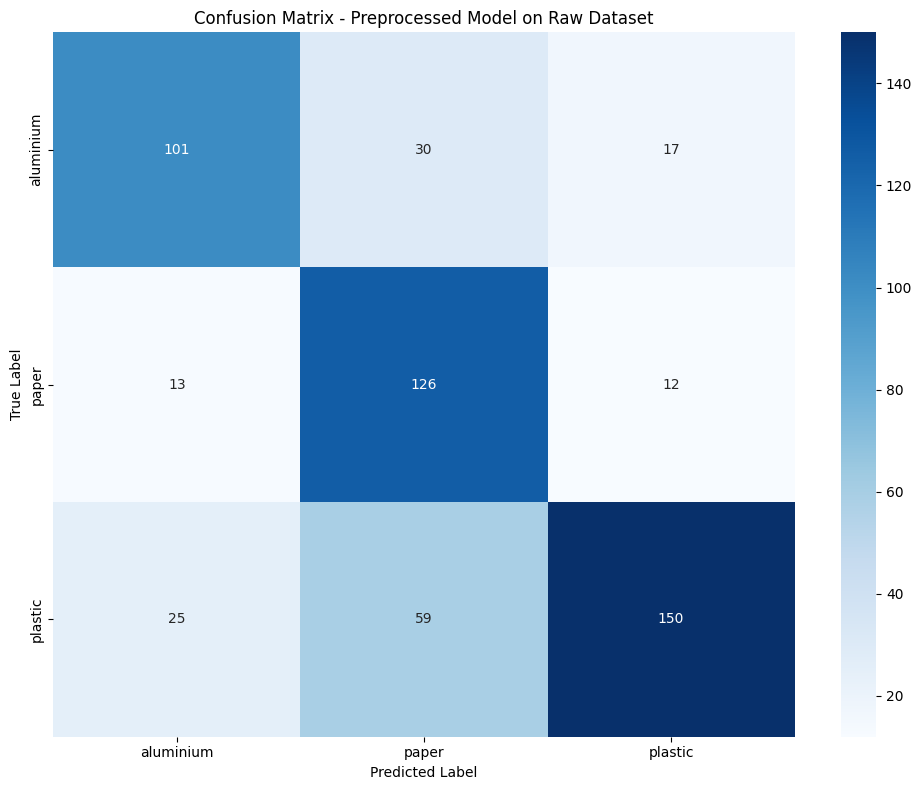


Results Summary - Preprocessed Model on Raw Dataset
Test Loss:      1.0835
Test Accuracy:  0.7073
Precision:      0.7357
Recall:         0.7073
F1-Score:       0.7094

✓ Results logged: EfficientNetB2 - Preprocessed_on_Raw
  Accuracy: 0.7073, Precision: 0.7357, Recall: 0.7073, F1: 0.7094
✓ Cross-dataset test completed and results logged


In [12]:
print("\n" + "#"*60)
print("# CROSS-DATASET TEST: PREPROCESSED MODEL ON RAW DATASET")
print("#"*60 + "\n")

if model_prep is not None:
    # Create test generator for raw dataset
    test_gen_raw_for_prep = ImageDataGenerator(
        preprocessing_function=preprocess_input
    ).flow_from_directory(
        RAW_SELF,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False,
        classes=CLASSES
    )
    
    # Evaluate preprocessed model on raw data
    results_prep_on_raw = evaluate_model(
        model_prep, 
        test_gen_raw_for_prep, 
        "Preprocessed Model on Raw Dataset"
    )
    
    # Log cross-dataset results
    log_result(
        model_name='EfficientNetB2',
        experiment_type='Preprocessed_on_Raw',
        accuracy=results_prep_on_raw['accuracy'],
        precision=results_prep_on_raw['precision'],
        recall=results_prep_on_raw['recall'],
        f1=results_prep_on_raw['f1'],
        loss=results_prep_on_raw['loss']
    )
    
    print("✓ Cross-dataset test completed and results logged")
else:
    print("❌ Preprocessed model not available for cross-dataset testing")

---
## 11. Comparison Summary
Compare results from both experiments


EFFICIENTNETB2 - FINAL COMPARISON
  Experiment  Accuracy  Precision   Recall  F1-Score     Loss
Preprocessed  0.643527   0.651889 0.643527  0.644632 1.188000
         Raw  0.748593   0.750989 0.748593  0.748987 0.960668




EFFICIENTNETB2 - FINAL COMPARISON
  Experiment  Accuracy  Precision   Recall  F1-Score     Loss
Preprocessed  0.643527   0.651889 0.643527  0.644632 1.188000
         Raw  0.748593   0.750989 0.748593  0.748987 0.960668



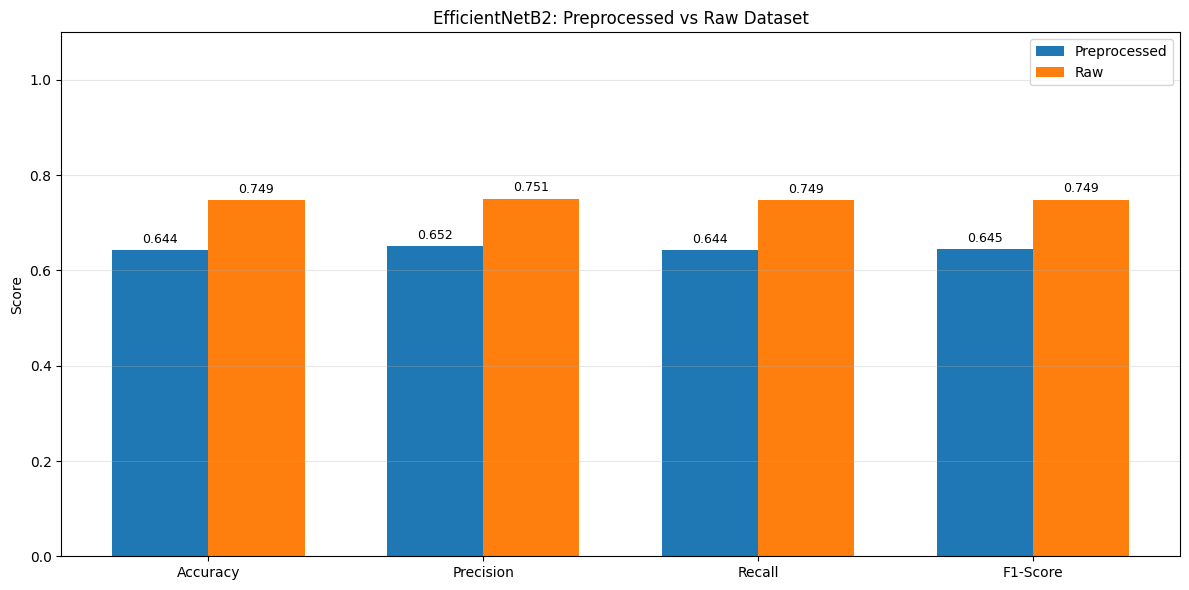


✓ All experiments completed successfully!
✓ Models saved in 'models/' directory
✓ Results logged to 'final_results.csv'


In [11]:
# Create comparison DataFrame
# Check if results variables exist, if not try to load and evaluate models
try:
    results_prep
except NameError:
    print("results_prep not defined, loading saved models...")
    # Load and evaluate if not already done
    if 'model_prep' not in locals() or model_prep is None:
        model_prep = load_saved_model('models/efficientnetb2_preprocessed.keras')
    if model_prep is not None:
        train_gen_prep, val_gen_prep, test_gen_prep = create_data_generators(
            PREPROCESSED_TRAIN, PREPROCESSED_VAL, PREPROCESSED_TEST_SELF, use_augmentation=False
        )
        results_prep = evaluate_model(model_prep, test_gen_prep, "EfficientNetB2 - Preprocessed")

try:
    results_raw
except NameError:
    print("results_raw not defined, loading saved models...")
    if 'model_raw' not in locals() or model_raw is None:
        model_raw = load_saved_model('models/efficientnetb2_raw.keras')
    if model_raw is not None:
        val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=0.2)
        train_gen_raw = val_datagen.flow_from_directory(RAW_PUBLIC, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', shuffle=True, classes=CLASSES, subset='training')
        val_gen_raw = val_datagen.flow_from_directory(RAW_PUBLIC, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False, classes=CLASSES, subset='validation')
        test_gen_raw = ImageDataGenerator(preprocessing_function=preprocess_input).flow_from_directory(RAW_SELF, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False, classes=CLASSES)
        results_raw = evaluate_model(model_raw, test_gen_raw, "EfficientNetB2 - Raw")

comparison_df = pd.DataFrame({
    'Experiment': ['Preprocessed', 'Raw'],
    'Accuracy': [results_prep['accuracy'], results_raw['accuracy']],
    'Precision': [results_prep['precision'], results_raw['precision']],
    'Recall': [results_prep['recall'], results_raw['recall']],
    'F1-Score': [results_prep['f1'], results_raw['f1']],
    'Loss': [results_prep['loss'], results_raw['loss']]
})

print("\n" + "="*80)
print("EFFICIENTNETB2 - FINAL COMPARISON")
print("="*80)
print(comparison_df.to_string(index=False))
print("="*80 + "\n")

# Visualize comparison
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x - width/2, 
               [results_prep['accuracy'], results_prep['precision'], 
                results_prep['recall'], results_prep['f1']], 
               width, label='Preprocessed')
bars2 = ax.bar(x + width/2, 
               [results_raw['accuracy'], results_raw['precision'], 
                results_raw['recall'], results_raw['f1']], 
               width, label='Raw')

ax.set_ylabel('Score')
ax.set_title('EfficientNetB2: Preprocessed vs Raw Dataset')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
ax.set_ylim([0, 1.1])
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontsize=9)

plt.tight_layout()
plt.show()

print("\n✓ All experiments completed successfully!")
print("✓ Models saved in 'models/' directory")
print("✓ Results logged to 'final_results.csv'")